# Visual results (pixel-wise class predictions and model uncertainty)

## Description

In this notebook, the main results of our best model are recreated. We show the prediction of the class labels and the model uncertainty for different images in the train, validation and test datasets. In order to do so, we use the method "visual_results" from the SegNet class which is imported in the first code line of this notebook. The "visual_results" method can take three arguments: 
1. ***dataset_type***: A string indicating the dataset type (either "TRAIN", "VAL" or "TEST"). By default it is "TEST".
2. ***images_index***: A list indicating the images indexes from the corresponding dataset. For instance, if we pass the list [0,20,47] we are requesting the prediction for the images that are found in the indexes 0, 20 and 47 of the dataset. This parameter can also be an integer value which corresponds to the number of different images that we want to display. In this case, we randomly pick the specified number of images from the corresponding dataset. By default it is set to 3.
3. ***FLAG_MAX_VOTE***: A boolean parameter indicating whether we want to use Max Voting (True) or Mean (False) at test time for the Bayesian model. By default it is set to False.


For each of the displayed images we show (1) the original image, (2) the ground truth, i.e., the given pixel labels for training the network and obtain prediction accuracies, (3) the output of our model for the given image, and (4) the uncertainty of the model prediction (the darker the color is, the more uncertain the prediction in this pixel is).

Finally, we also show the color legend for the different classes.

## Usage

In order to run this notebook you need to have the files from https://github.com/toimcio/SegNet-tensorflow in the same directory than this notebook. Moreover, you need the 'vgg16.npy' file also in the running directory, which can be found in this link: https://mega.nz/#!YU1FWJrA!O1ywiCS2IiOlUCtCpI6HTJOMrneN-Qdv3ywQP5poecM. Finally, you need to download a saved model from https://drive.google.com/drive/folders/1tD-4FsN6s8c45R81bjqIG_f5VCS1j-Db and write the folder where the saved model is put into the 'config.json' file under "SAVE_MODEL_DIR" (see the current value of "SAVE_MODEL_DIR" in the 'config.json' file as an example).

## Imports

In [1]:
from SegNet import SegNet
from drawings_object import display_color_legend

## Train dataset (367 images)

VGG parameter loaded
INFO:tensorflow:Restoring parameters from ./saved_models/segnet_vgg_bayes/segnet_vgg_bayes_MFL_17000/model.ckpt-17000
367 CamVid test images are loaded


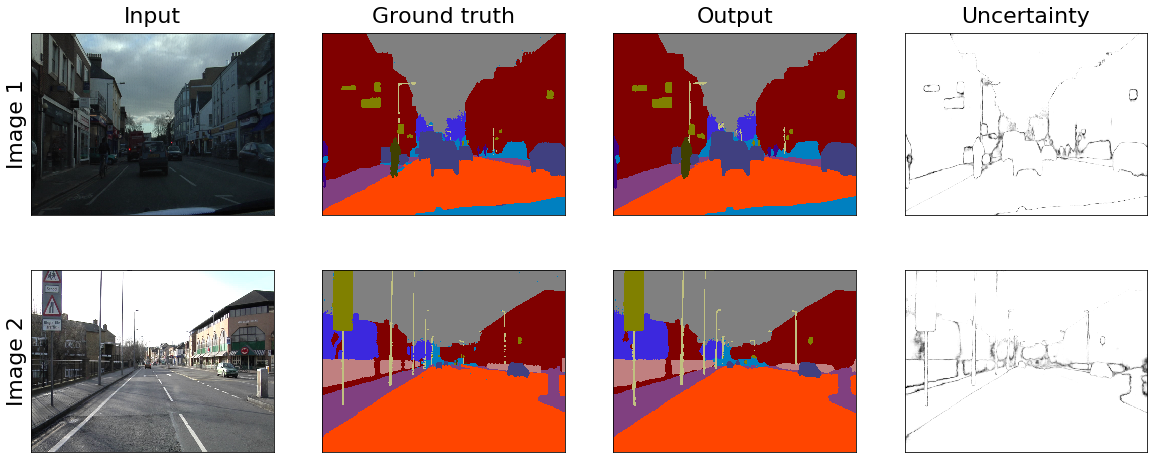

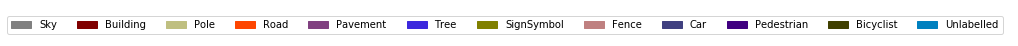

In [2]:
SegNet().visual_results(dataset_type = "TRAIN", images_index = 2, FLAG_MAX_VOTE = False)
display_color_legend()

## Validation dataset (101 images)

VGG parameter loaded
INFO:tensorflow:Restoring parameters from ./saved_models/segnet_vgg_bayes/segnet_vgg_bayes_MFL_17000/model.ckpt-17000
101 CamVid test images are loaded


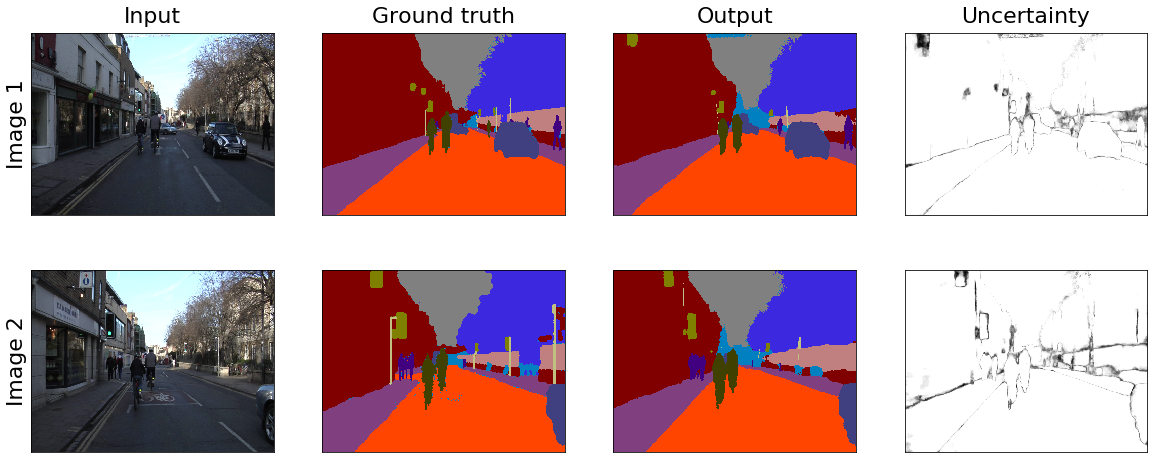

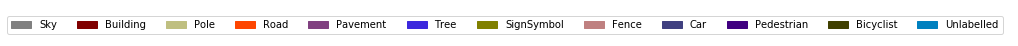

In [4]:
SegNet().visual_results("VAL", [0,50], False)
display_color_legend()

## Test dataset (233 images)

VGG parameter loaded
INFO:tensorflow:Restoring parameters from ./saved_models/segnet_vgg_bayes/segnet_vgg_bayes_MFL_17000/model.ckpt-17000
233 CamVid test images are loaded


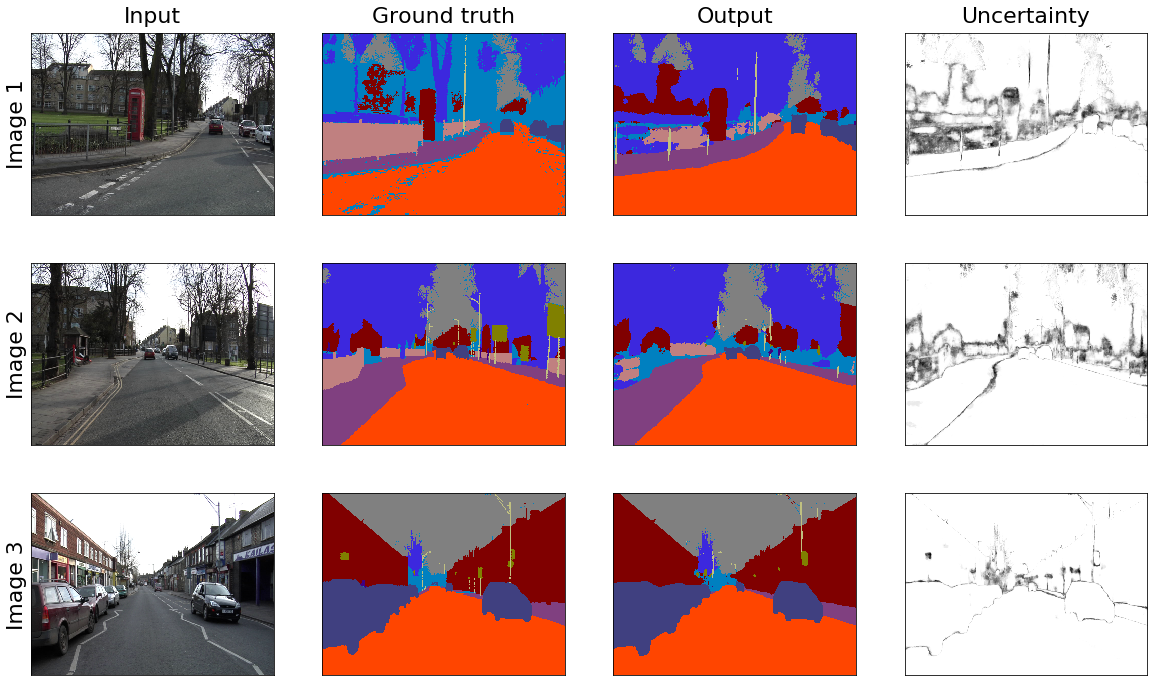

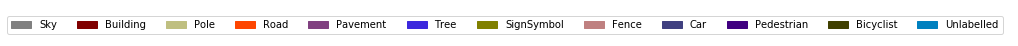

In [4]:
# Index of the image with the worst global accuracy: 62
# Index of the image with an average global accuracy: 66
# Index of the image with the best global accuracy: 198
SegNet().visual_results("TEST", [62,66,198], False)
display_color_legend()